In [3]:
import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
from shapely.errors import TopologicalError
import functools
%load_ext autoreload
%autoreload 2
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from genpen.utils import Paper

In [4]:
from skimage import exposure

from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk

def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)


In [3]:
page_x_inches: float = 11 # inches
page_y_inches: float = 17 # inches
border:float = 30.


In [4]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-border, py-border)

xmin, ymin, xmax, ymax = drawbox.bounds

start_area = drawbox.buffer(-10, cap_style=3, join_style=3)


In [ ]:
image_path = Path('/mnt/c/code/side/plotter_images/test2.jpg')

In [ ]:
img = io.imread(image_path)
img = rgb2gray(img)

img = rescale(img, 1)

# x, y = np.mgrid[-10:10:255j, -10:10:255j]
# img = np.sin(x ** 2 + y ** 2)

In [ ]:
selem = disk(2)
img = filters.rank.mean(img/img.max(), selem)

In [ ]:
angle_farid = angle(filters.farid_h(img),
                    filters.farid_v(img))

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(angle_farid)

In [ ]:
class ImageFlowField(object):

    def __init__(self, img, shape=None):
        img = img.T
        if shape == None:
            shape = img.shape
        self.p = box(0, 0, shape[1], shape[0])
        self.xbins, self.ybins = gp.overlay_grid(self.p, 1, 1)
        self.gxs, self.gys = np.meshgrid(self.xbins, self.ybins)

        self.z = resize(img, shape)
        self.a = np.interp(self.z, [self.z.min(), self.z.max()], [np.pi, 0])


In [ ]:
flo = ImageFlowField(angle_farid)

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
ax.quiver(np.cos(flo.a), np.sin(flo.a), scale=100)

In [ ]:
intensity_vec = flo.z.ravel()

In [ ]:
n_points = 1000

In [ ]:
choice_inds = np.random.choice(len(intensity_vec), size=n_points, p=intensity_vec/intensity_vec.sum())

In [ ]:
choice_vec = np.zeros_like(intensity_vec)
choice_vec[choice_inds] = 1
choice_locs = choice_vec.reshape(flo.z.shape)

ycs, xcs = np.where(choice_locs)

In [ ]:
# xcs, ycs = gp.overlay_grid(flo.p.buffer(-10), xstep=3, ystep=3)
start_pts = [Point(x,y) for x,y in zip(xcs, ycs)]

start_pts = [p for p in start_pts if flo.p.contains(p)]

In [ ]:
sg.GeometryCollection(start_pts + [flo.p.boundary])

In [ ]:
particles = [gp.Particle(pos=p, grid=flo, stepsize=0.7) for p in start_pts]

In [ ]:
for p in particles:
    for i in range(560):
        p.step()

In [ ]:
mls = MultiLineString([p.line for p in particles if p.line.length>0])

In [ ]:
sg.GeometryCollection([mls]+ [flo.p.boundary])

In [ ]:
mls = gp.make_like(mls, drawbox)

In [ ]:
buffers = mls.buffer(0.05, cap_style=2, join_style=2).boundary

In [ ]:
sk = vsketch.Vsketch()
sk.size(page_format)
sk.scale('1mm')
sk.penWidth('0.25mm')
# sk.geometry(mls)
sk.geometry(buffers)
sk.display(color_mode='None')

In [ ]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0113_louie_flow.svg'

sk.save(savepath)

vpype_commands = 'reloop linesimplify --tolerance 0.05mm linemerge --tolerance 0.3mm linesort'
vpype_str = f'vpype read -q 0.05mm {savepath} {vpype_commands} write {savepath}'

os.system(vpype_str)

## just intensity

In [ ]:
page_x_inches: float = 17 # inches
page_y_inches: float = 11 # inches
border:float = 30.


In [ ]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-border, py-border)

xmin, ymin, xmax, ymax = drawbox.bounds


In [ ]:
selem = disk(2)
img = filters.rank.mean(img/img.max(), selem)

In [ ]:
img = io.imread(image_path)
img = rgb2gray(img)

img = rescale(img, 0.5)

# x, y = np.mgrid[-10:10:255j, -10:10:255j]
# img = np.sin(x ** 2 + y ** 2)

In [ ]:
def sample_points_from_matrix(matrix, n_points):
    vec = matrix.ravel()
    choice_inds = np.random.choice(len(vec), size=n_points, p=vec/vec.sum())
    choice_vec = np.zeros_like(vec)
    choice_vec[choice_inds] = 1
    choice_locs = choice_vec.reshape(matrix.shape)
    ycs, xcs = np.where(choice_locs)
    return [Point(x, y) for x,y in zip(xcs, ycs)]

In [ ]:
pts = sample_points_from_matrix(img**2, n_points=12000)

In [ ]:
pts = gp.make_like(MultiPoint(pts), drawbox)

In [ ]:
cs = MultiLineString([pt.buffer(0.9, resolution=4).boundary for pt in pts])

In [ ]:
csb = so.unary_union([c.buffer(0.1) for c in cs])

In [ ]:
tris = MultiPolygon(so.triangulate(MultiPoint(pts)))
# tris = gp.make_like(tris, drawbox)

In [ ]:
sns.displot([np.log10(t.area) for t in tris])

In [ ]:
# tris = tris.buffer(-0.2, join_style=2, cap_style=2, resolution=2)
ftris = MultiPolygon([p for p in tris if p.area <5])

In [ ]:
uftris = so.unary_union(ftris)

In [ ]:
stp = gp.ScaleTransPrms(n_iters=100, d_buffer=-0.3, d_translate_factor=0.6, angles=np.radians(-60))
stp.d_buffers *= gp.gaussian_random_walk(n=stp.d_buffers.shape[0], step_std=10)

all_fills = []
for p in uftris:
    fills = gp.scale_trans(p, **stp.prms)
    mfills = gp.merge_LineStrings([f.boundary for f in fills])
    all_fills.append(mfills)

fill_layer = gp.merge_LineStrings(all_fills)

In [ ]:
sk = vsketch.Vsketch()
sk.size(page_format)
sk.scale('1mm')
sk.penWidth('0.25mm')
# sk.geometry(csb.boundary)
# sk.geometry(fill_layer)
sk.geometry(ftris.boundary)
sk.display(color_mode='None')

In [ ]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0115_louie_delauney_flat.svg'

sk.save(savepath)

vpype_commands = 'reloop linesimplify --tolerance 0.05mm linemerge --tolerance 0.3mm linesort'
vpype_str = f'vpype read -q 0.05mm {savepath} {vpype_commands} write {savepath}'

os.system(vpype_str)

## just intensity

In [ ]:
page_x_inches: float = 17 # inches
page_y_inches: float = 11 # inches
border:float = 30.


In [ ]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-border, py-border)

xmin, ymin, xmax, ymax = drawbox.bounds


In [ ]:
img = io.imread(image_path)
img = rgb2gray(img)

img = rescale(img, 0.95)

# x, y = np.mgrid[-10:10:255j, -10:10:255j]
# img = np.sin(x ** 2 + y ** 2)

In [ ]:
def sample_points_from_matrix(matrix, n_points):
    vec = matrix.ravel()
    choice_inds = np.random.choice(len(vec), size=n_points, p=vec/vec.sum())
    choice_vec = np.zeros_like(vec)
    choice_vec[choice_inds] = 1
    choice_locs = choice_vec.reshape(matrix.shape)
    ycs, xcs = np.where(choice_locs)
    return [Point(x, y) for x,y in zip(xcs, ycs)]

In [ ]:
pts = sample_points_from_matrix(img**2, n_points=12000)

In [ ]:
pts = gp.make_like(MultiPoint(pts), drawbox)

In [ ]:
cs = MultiLineString([pt.buffer(0.9, resolution=4).boundary for pt in pts])

In [ ]:
csb = so.unary_union([c.buffer(0.1) for c in cs])

In [ ]:
tris = MultiPolygon(so.triangulate(MultiPoint(pts)))
tris = tris.buffer(-0.25, join_style=2, cap_style=2, resolution=2)

In [ ]:
def split_LineString(ls):
    vertices = len(ls.coords)-1
    return [LineString((ls.coords[i], ls.coords[i+1])) for i in range(vertices)]

In [ ]:
all_lines = []
for ls in tri_edges:
    all_lines += split_LineString(ls)

In [ ]:
max_length = 15
flines = MultiLineString([l for l in all_lines if l.length<max_length])

In [ ]:
# tris = tris.buffer(-0.2, join_style=2, cap_style=2, resolution=2)
ftris = MultiPolygon([p for p in tris if p.area <1])

In [ ]:
uftris = so.unary_union(ftris)

In [ ]:
stp = gp.ScaleTransPrms(n_iters=100, d_buffer=-0.3, d_translate_factor=0.6, angles=np.radians(-60))
stp.d_buffers *= gp.gaussian_random_walk(n=stp.d_buffers.shape[0], step_std=10)

all_fills = []
for p in rts:
    fills = gp.scale_trans(p, **stp.prms)
    mfills = gp.merge_LineStrings([f.boundary for f in fills])
    all_fills.append(mfills)

fill_layer = gp.merge_LineStrings(all_fills)

In [ ]:
sk = vsketch.Vsketch()
sk.size(page_format)
sk.scale('1mm')
sk.penWidth('0.25mm')
# sk.geometry(csb.boundary)
# sk.geometry(fill_layer)
# sk.geometry(ftris.boundary)
sk.geometry(flines)
sk.display(color_mode='None')

In [ ]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0115_louie_delauney_flat.svg'

sk.save(savepath)

vpype_commands = 'reloop linesimplify --tolerance 0.05mm linemerge --tolerance 0.3mm linesort'
vpype_str = f'vpype read -q 0.05mm {savepath} {vpype_commands} write {savepath}'

os.system(vpype_str)

## intensity pixel remap

In [5]:
image_path = Path('/mnt/c/code/side/plotter_images/louiehat.jpg')

In [6]:
page_x_inches: float = 17 # inches
page_y_inches: float = 11 # inches
border:float = 15.


In [270]:
size_string = '11.7×16.5 inches'

In [271]:
size, units = size_string.split(' ')

In [275]:
size.split('x')

['11.7×16.5']

In [280]:
ppr = utils.Paper('A3')

In [7]:
px = utils.DistanceConverter(page_x_inches, 'inches').mm
py = utils.DistanceConverter(page_y_inches, 'inches').mm
page_format = f'{px}mmx{py}mm'
drawbox = sg.box(border, border, px-xborder, py-yborder)

xmin, ymin, xmax, ymax = drawbox.bounds


In [8]:
img =  rgb2gray(io.imread(image_path))
img = rgb2gray(img)

img = rescale(img, 0.125)


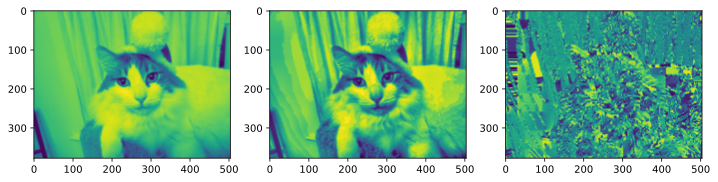

In [11]:
# Contrast stretching
# p2, p98 = np.percentile(img, (2, 99))
# img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98)) * 0.8 +0.1

img_rescale = exposure.equalize_adapthist(img, clip_limit=0.1, nbins=32) * 0.79 +0.2

selem = disk(2)
filt_img = filters.rank.mean(img_rescale, selem)

angle_farid = angle(filters.farid_h(filt_img),
                    filters.farid_v(filt_img))

f, axs = plt.subplots(1,3, figsize=(12,8))
axs[0].imshow(img)
axs[1].imshow(img_rescale)
axs[2].imshow(angle_farid)

In [25]:
df = geopandas.GeoDataFrame({'geometry':polys})

In [28]:
pixel_width=0.9
pixel_height=0.9

In [199]:
prms = []
for y, row in tqdm(enumerate(img_rescale)):
    for x, intensity in enumerate(row):
        
        p = gp.centered_box(Point(x, y), width=pixel_width, height=pixel_height)
        a = angle_farid[y, x]
        prm = {
            'geometry':p,
            'x':x,
            'y':y,
            'raw_pixel_width':pixel_width,
            'raw_pixel_height':pixel_height,
            'intensity': intensity,
            'angle':a,
            'group': 'raw_hatch_pixel',
            
        }
        prms.append(prm)
raw_hatch_pixels = geopandas.GeoDataFrame(prms)

378it [00:08, 45.99it/s]


In [256]:
import yaml

In [257]:
@dataclass
class RasterHatchParam(gp.DataClassBase):
    image_path: str = None

In [260]:
rhp = RasterHatchParam(image_path='/mnt/c/code/side/plotter_images/louiehat.jpg')

In [262]:
rhp.angle_jitter_gen = angle_jitter_gen

In [263]:
with open('/mnt/c/data/test_param.yaml', mode='w') as ff:
    ff.write(yaml.dump(rhp))


In [264]:
with open('/mnt/c/data/test_param.yaml', mode="r") as fx:
    y = yaml.load(fx)

<ipython-input-264-9c7c6d0cbd19>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  y = yaml.load(fx)


ConstructorError: could not determine a constructor for the tag 'tag:yaml.org,2002:python/object/apply:builtins.getattr'
  in "/mnt/c/data/test_param.yaml", line 2, column 19

In [201]:
bbox = box(*raw_hatch_pixels.total_bounds)
_, transform = gp.make_like(bbox, drawbox, return_transform=True)
A = gp.AffineMatrix(**transform)

In [202]:
scaled_hatch_pixels = raw_hatch_pixels.copy()
scaled_hatch_pixels['geometry'] = scaled_hatch_pixels.affine_transform(A.A_flat)
scaled_hatch_pixels['scaled_pixel_height'] = scaled_hatch_pixels['geometry'].apply(gp.get_height)
scaled_hatch_pixels['scaled_pixel_width'] = scaled_hatch_pixels['geometry'].apply(gp.get_width)

In [251]:
angle_jitter_gen = gp.make_callable(ss.norm(loc=0, scale=10).rvs)
pixel_rotation_gen = gp.make_callable(0)

In [255]:
new_rows = []
for i, row in tqdm(scaled_hatch_pixels.iterrows(), total=len(scaled_hatch_pixels)):
    r = row.copy()
    r['angle_jitter'] = angle_jitter_gen()
    r['hatch_angle'] = r['angle'] + r['angle_jitter']
    r['pixel_rotation'] = pixel_rotation_gen()
    p = r['geometry']
    r['spacing'] = r['intensity']  # could be a transformation though
    if abs(r['pixel_rotation']) > np.finfo(float).eps:
        p = sa.rotate(p, r['pixel_rotation'])
    f = gp.hatchbox(p, spacing=r['spacing'], angle=r['hatch_angle'])
    r['geometry'] = f
    new_rows.append(r)
    
fills = geopandas.GeoDataFrame(new_rows)
fills = fills[fills.length > 0]

100%|██████████| 190512/190512 [02:55<00:00, 1088.49it/s]


In [13]:
sk = vsketch.Vsketch()
sk.size(page_format)
sk.scale('1mm')
sk.penWidth('0.25mm')
sk.stroke(1)
sk.geometry(fills)

In [15]:
for tolerance in np.linspace(0.3, 0.9, 6):
    sk.vpype(f'linemerge --tolerance {tolerance}mm')

In [16]:
sk.vpype('linesimplify --tolerance 0.2mm')

In [17]:
%%time
sk.vpype('linesort')

CPU times: user 1.16 s, sys: 213 µs, total: 1.17 s
Wall time: 1.17 s


In [ ]:
sk.display(color_mode='None')

In [250]:
savepath = '/mnt/c/code/side/plotter_images/oned_outputs/0138_louie_flow_high_res_jittered_angle.svg'

sk.save(savepath)


In [283]:
image_path='/mnt/c/code/side/plotter_images/joey_bun.jpg'
filename='138_joeybun_test.svg'

In [284]:
paper_size:str = '11x17 inches'
border:float=20  # mm
image_rescale_factor:float=0.04
farid_disk_size:int=2
hist_clip_limit=0.1
hist_nbins=32
hatch_spacing_min=0.2  # mm
hatch_spacing_max=1.  # mm
pixel_width=0.9  # mm
pixel_height=0.9  # mm
angle_jitter='0'
pixel_rotation='0'
merge_tolerances=[0.3, 0.4, 0.5]  # mm
simplify_tolerances=[0.2]  # mm
savedir='/mnt/c/code/side/plotter_images/oned_outputs'

In [288]:
def local_angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

# make page
paper = Paper(paper_size)
drawbox = paper.get_drawbox(border)

# load
img =  rgb2gray(io.imread(Path(image_path)))
img_rescale = rescale(img, image_rescale_factor)

# 
img_contrast_adj = exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip_limit, nbins=hist_nbins)
img_renorm = img_contrast_adj * (hatch_spacing_max - hatch_spacing_min) + hatch_spacing_min

# calc dominant angle
selem = disk(2)
filt_img = filters.rank.mean(img_renorm, selem)
angle_farid = local_angle(filters.farid_h(filt_img), filters.farid_v(filt_img))

# make pixel polys
prms = []
for y, row in tqdm(enumerate(img_renorm)):
    for x, intensity in enumerate(row):

        p = gp.centered_box(Point(x, y), width=pixel_width, height=pixel_height)
        a = angle_farid[y, x]
        prm = {
            'geometry':p,
            'x':x,
            'y':y,
            'raw_pixel_width':pixel_width,
            'raw_pixel_height':pixel_height,
            'intensity': intensity,
            'angle':a,
            'group': 'raw_hatch_pixel',

        }
        prms.append(prm)
raw_hatch_pixels = geopandas.GeoDataFrame(prms)

#  rescale polys to fit in drawbox
bbox = box(*raw_hatch_pixels.total_bounds)
_, transform = gp.make_like(bbox, drawbox, return_transform=True)
A = gp.AffineMatrix(**transform)
scaled_hatch_pixels = raw_hatch_pixels.copy()
scaled_hatch_pixels['geometry'] = scaled_hatch_pixels.affine_transform(A.A_flat)
scaled_hatch_pixels['scaled_pixel_height'] = scaled_hatch_pixels['geometry'].apply(gp.get_height)
scaled_hatch_pixels['scaled_pixel_width'] = scaled_hatch_pixels['geometry'].apply(gp.get_width)

# distributions etc
angle_jitter_gen = gp.make_callable(eval(angle_jitter))
pixel_rotation_gen = gp.make_callable(eval(pixel_rotation))


new_rows = []
for i, row in tqdm(scaled_hatch_pixels.iterrows(), total=len(scaled_hatch_pixels)):
    r = row.copy()
    r['angle_jitter'] = angle_jitter_gen()
    r['hatch_angle'] = r['angle'] + r['angle_jitter']
    r['pixel_rotation'] = pixel_rotation_gen()
    p = r['geometry']
    r['spacing'] = r['intensity']  # could be a transformation though
    if abs(r['pixel_rotation']) > np.finfo(float).eps:
        p = sa.rotate(p, r['pixel_rotation'])
    f = gp.hatchbox(p, spacing=r['spacing'], angle=r['hatch_angle'])
    r['geometry'] = f
    new_rows.append(r)

fills = geopandas.GeoDataFrame(new_rows)
fills = fills[fills.length > 0]

121it [00:00, 139.63it/s]
100%|██████████| 19481/19481 [00:43<00:00, 451.17it/s]


In [291]:
fill_layer = gp.merge_LineStrings(fills.geometry)

In [293]:
fills

,geometry,x,y,raw_pixel_width,raw_pixel_height,intensity,angle,group,scaled_pixel_height,scaled_pixel_width,angle_jitter,hatch_angle,pixel_rotation,spacing
0,"MULTILINESTRING ((-88.496 -231.408, -87.157 -2...",0,0,0.9,0.9,0.852474,1.757906,raw_hatch_pixel,1.339093,1.339093,0,1.757906,0,0.852474
1,"MULTILINESTRING ((-87.008 -231.407, -85.669 -2...",1,0,0.9,0.9,0.852474,1.710887,raw_hatch_pixel,1.339093,1.339093,0,1.710887,0,0.852474
2,"MULTILINESTRING ((-85.520 -231.407, -84.181 -2...",2,0,0.9,0.9,0.852474,1.675873,raw_hatch_pixel,1.339093,1.339093,0,1.675873,0,0.852474
3,"MULTILINESTRING ((-84.032 -231.326, -82.693 -2...",3,0,0.9,0.9,0.691541,1.639676,raw_hatch_pixel,1.339093,1.339093,0,1.639676,0,0.691541
4,"MULTILINESTRING ((-82.544 -231.519, -81.205 -2...",4,0,0.9,0.9,0.538711,1.636008,raw_hatch_pixel,1.339093,1.339093,0,1.636008,0,0.538711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19476,"MULTILINESTRING ((143.613 -53.008, 144.952 -52...",156,120,0.9,0.9,0.569650,1.972690,raw_hatch_pixel,1.339093,1.339093,0,1.972690,0,0.569650
19477,"MULTILINESTRING ((145.101 -53.005, 146.440 -52...",157,120,0.9,0.9,0.569994,1.687779,raw_hatch_pixel,1.339093,1.339093,0,1.687779,0,0.569994
19478,"MULTILINESTRING ((146.589 -53.005, 147.928 -52...",158,120,0.9,0.9,0.570338,1.680017,raw_hatch_pixel,1.339093,1.339093,0,1.680017,0,0.570338
19479,"MULTILINESTRING ((148.077 -52.926, 149.416 -52...",159,120,0.9,0.9,0.490239,1.746426,raw_hatch_pixel,1.339093,1.339093,0,1.746426,0,0.490239


debug

In [21]:
border=20
paper_size:str = '14x11 inches'  
        # make page
paper = Paper(paper_size)
drawbox = paper.get_drawbox(border)

In [6]:
image_path = '/mnt/c/code/side/plotter_images/205_subdivide.png'
image_rescale_factor = 0.01
smooth_disk_size:int=2
hist_clip_limit=0.1
hist_nbins=32
hatch_spacing_min=0.3  # mm
hatch_spacing_max=1.  # mm
pixel_width=0.9  # mm
pixel_height=0.9 # mm

In [23]:
angle_jitter='0'  # degrees
pixel_rotation='0' # degrees
merge_tolerances=[0.3, 0.4, 0.5]  # mm
simplify_tolerances=[0.2]  # mm

In [8]:
def local_angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)

In [14]:
# load
img =  rgb2gray(io.imread(Path(image_path)))
img_rescale = rescale(img, image_rescale_factor)

# 
img_renorm = exposure.equalize_adapthist(img_rescale, clip_limit=hist_clip_limit, nbins=hist_nbins)

# calc dominant angle
selem = disk(smooth_disk_size)
filt_img = filters.rank.mean(img_renorm, selem)
angle_farid = local_angle(filters.farid_h(filt_img), filters.farid_v(filt_img))

<ipython-input-14-7459d1b02e0e>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img =  rgb2gray(io.imread(Path(image_path)))
/home/anaka/anaconda3/envs/genpen/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
# make pixel polys
prms = []
for y, row in tqdm(enumerate(img_renorm)):
    for x, intensity in enumerate(row):

        p = gp.centered_box(Point(x, y), width=pixel_width, height=pixel_height)
        a = np.degrees(angle_farid[y, x])
        prm = {
            'geometry':p,
            'x':x,
            'y':y,
            'raw_pixel_width':pixel_width,
            'raw_pixel_height':pixel_height,
            'intensity': intensity,
            'angle':a,
            'group': 'raw_hatch_pixel',

        }
        prms.append(prm)
raw_hatch_pixels = geopandas.GeoDataFrame(prms)

33it [00:00, 368.41it/s]


In [24]:
#  rescale polys to fit in drawbox
bbox = box(*raw_hatch_pixels.total_bounds)
_, transform = gp.make_like(bbox, drawbox, return_transform=True)
A = gp.AffineMatrix(**transform)
scaled_hatch_pixels = raw_hatch_pixels.copy()
scaled_hatch_pixels['geometry'] = scaled_hatch_pixels.affine_transform(A.A_flat)
scaled_hatch_pixels['scaled_pixel_height'] = scaled_hatch_pixels['geometry'].apply(gp.get_height)
scaled_hatch_pixels['scaled_pixel_width'] = scaled_hatch_pixels['geometry'].apply(gp.get_width)

# distributions etc
angle_jitter_gen = gp.make_callable(eval(angle_jitter))
pixel_rotation_gen = gp.make_callable(eval(pixel_rotation))


scaled_hatch_pixels['angle_jitter'] = angle_jitter_gen(len(scaled_hatch_pixels))
scaled_hatch_pixels['hatch_angle'] = scaled_hatch_pixels['angle'] + scaled_hatch_pixels['angle_jitter']
scaled_hatch_pixels['pixel_rotation'] = pixel_rotation_gen(len(scaled_hatch_pixels))

In [27]:
spacing_func = functools.partial(np.interp, xp=[0, 1], fp=[hatch_spacing_min, hatch_spacing_max])

In [28]:
scaled_hatch_pixels['spacing'] = spacing_func(scaled_hatch_pixels['intensity'])

In [29]:
scaled_hatch_pixels['spacing']

0       0.419650
1       0.472396
2       0.577935
3       0.630682
4       0.630682
          ...   
1876    1.000000
1877    1.000000
1878    0.971688
1879    1.000000
1880    1.000000
Name: spacing, Length: 1881, dtype: float64

In [ ]:
r['spacing'] = r['intensity']